<a href="https://colab.research.google.com/github/aksekhar/face_detection_system/blob/main/Face_Recognition_Part_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DOMAIN: **Face Recognition

**• CONTEXT:** Company X intends to build a face identification model to recognise human faces.

**• DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.

**• PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

Steps and tasks:  

1. Unzip, read and Load data(‘PINS.zip’) into session.

2. Write function to create metadata of the image.  

Hint: Metadata means derived information from the available data which can be useful for particular problem statement.

3. Write a loop to iterate through each and every image and create metadata for all the images.  

4. Generate Embeddings vectors on the each face in the dataset.
Hint: Use ‘vgg_face_weights.h5’

5. Build distance metrics for identifying the distance between two similar and dissimilar images.  

6. Use PCA for dimensionality reduction.  

7. Build an SVM classifier in order to map each image to its right person.  
8. Import and display the the test images.  

Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.

9. Use the trained SVM model to predict the face on both test images.  

In [3]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

import os


In [4]:
current_dir = "/content/drive/MyDrive/dataset/Pinterest/"
images_zip_path = os.path.join(current_dir, 'PINS.zip')
images_zip_path

'/content/drive/MyDrive/dataset/Pinterest/PINS.zip'

In [5]:
with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [6]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

In [7]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
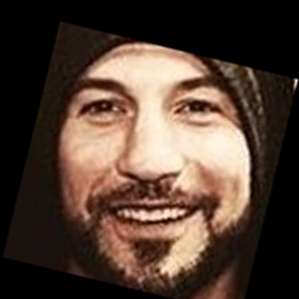

In [8]:
load_image(metadata[0].image_path())

In [9]:

from tensorflow.keras.models import model_from_json
facefilepath = "/content/drive/MyDrive/dataset/vgg_face_weights.h5"

In [10]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [11]:
model = vgg_face()
model.load_weights(facefilepath)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [12]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

generate embeddings for each image in the dataset

Example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [13]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 2s 2s/step
(2622,)


Iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings.

In [14]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step


Function to calculate distance between given 2 pairs of images.


Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [30]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [31]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

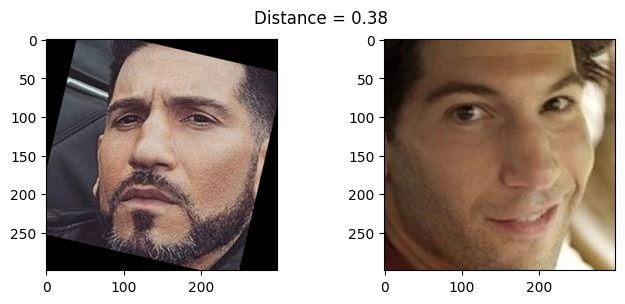

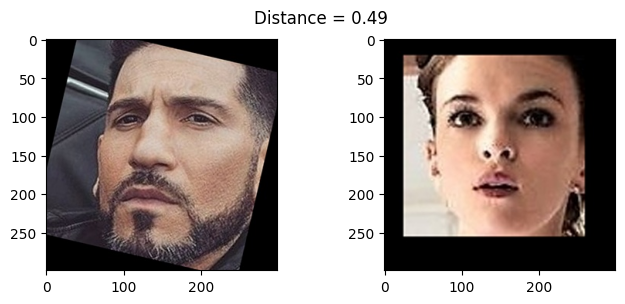

In [32]:
show_pair(2, 3)
show_pair(2, 100)

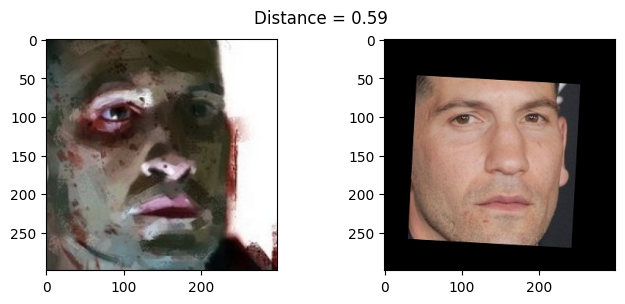

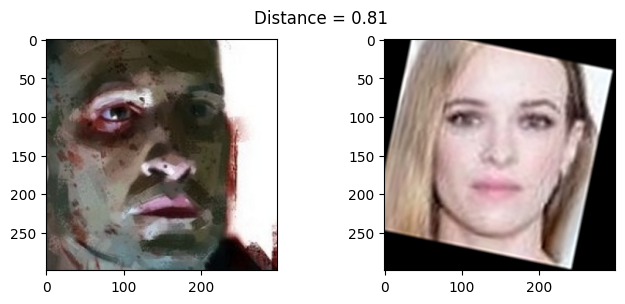

In [33]:
show_pair(30, 31)
show_pair(30, 90)

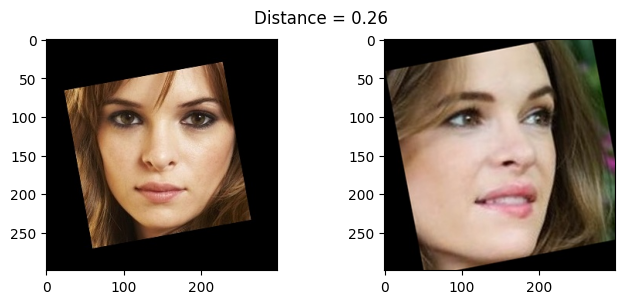

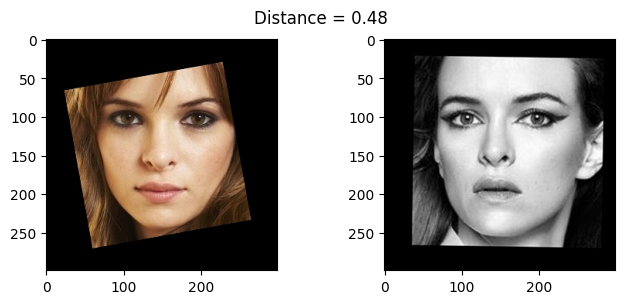

In [34]:
show_pair(70, 72)
show_pair(70, 82)

Create train and test sets

Create X_train, X_test and y_train, y_test

Use train_idx to seperate out training features and labels

Use test_idx to seperate out testing features and labels

In [35]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

Encode the labels by using LabelEncoder

In [36]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

Standardize the feature values

Scale the features using StandardScaler

In [37]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Reduce dimensions using PCA

Reduce feature dimensions using Principal Component Analysis

In [38]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.54024061  18.9044249   22.86329653 ...  99.99999983  99.99999999
 100.        ]


In [39]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 347


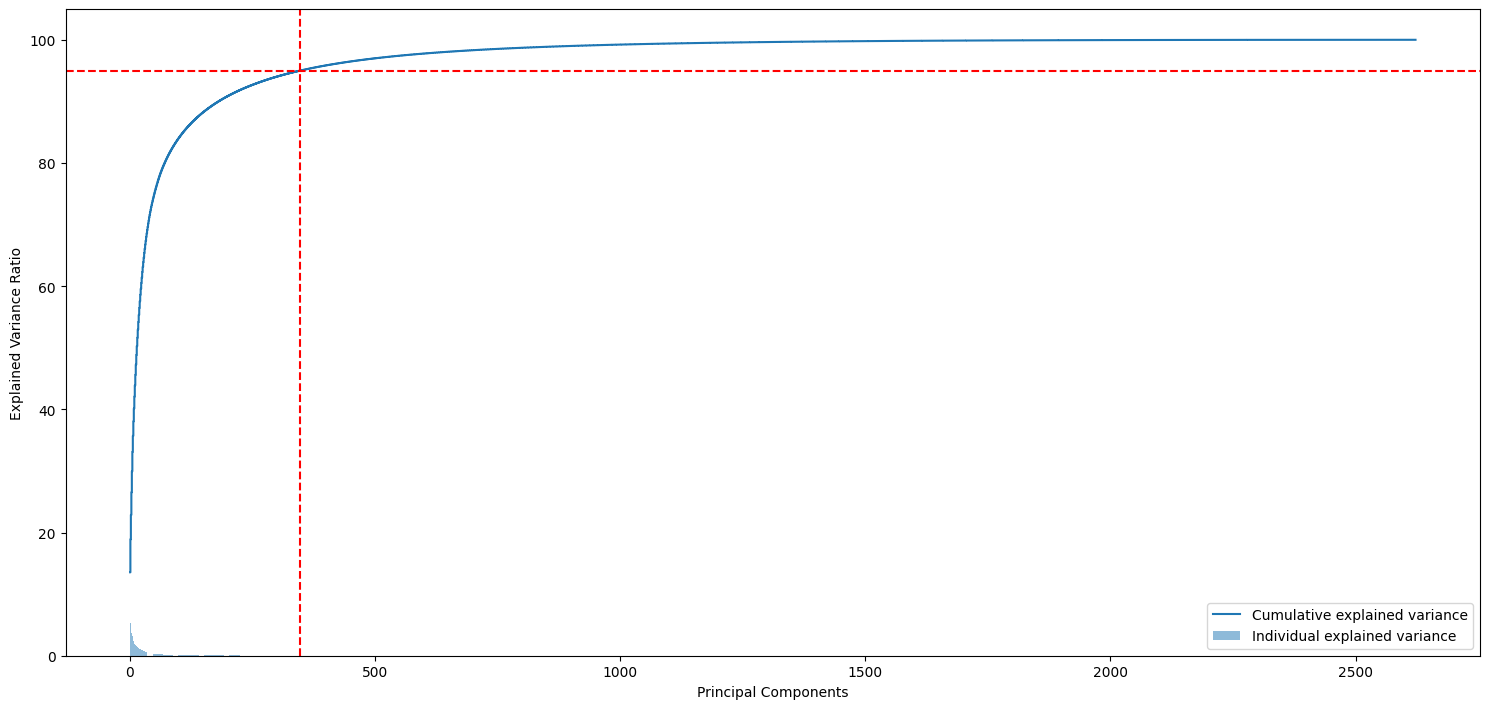

In [40]:
# Ploting
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [41]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

SVM Classifier to predict the person in the given image

Fit the classifier and print the score

In [42]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [43]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.97


In [45]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 0s 28ms/step


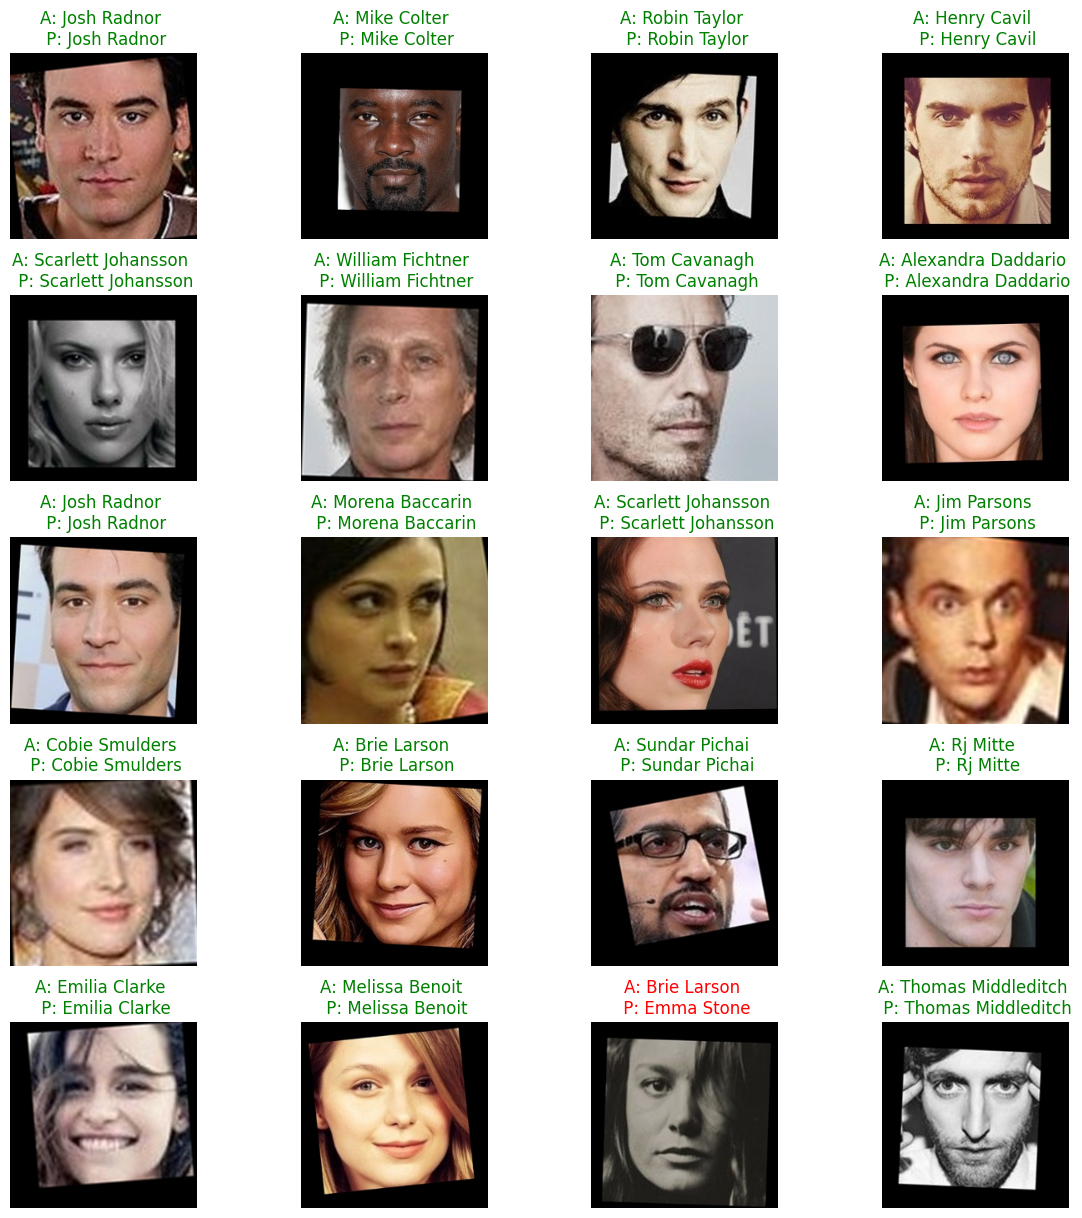

In [46]:
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3)

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))

    plt.axis('off')
    plt.imshow(sample_img)

    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()